# Package

In [8]:
import pandas as pd
import numpy as np
import os
import datetime
from tqdm import tqdm, trange          #用來掌管 for 進度
import monpa                                                 
from monpa import utils
import re                                          

from sklearn.feature_extraction.text import TfidfVectorizer  #把所有關鍵字變成文字向量模型的套件
from sklearn.feature_selection import SelectKBest            #用來挑出最好幾個的關鍵字的套件
from sklearn.feature_selection import chi2                   #SelectKBest 要輸入的 score function

# Path
rawdata_path = '/Users/alexlo/Desktop/Project/Project_MLEM/rawdata'
workdata_path = '/Users/alexlo/Desktop/Project/Project_MLEM/workdata'

# Load Data

In [3]:
### 設定的參數（有需要的話，可以直接修改成股票代碼以及股票檔案）
start_date = datetime.date(2019,1,1) 
end_date = datetime.date(2021,1,1) 
code =  '2303'
keywords = ['聯電'] #公司名字（各種可能名字）、產業名字
keywords_times_titles = 1
keywords_times_content = 2

### 讀取文章資料
os.chdir(rawdata_path)
article_df = pd.read_csv('bda2022_mid_bbs_2019-2021.csv')
article_df = article_df.rename(columns={'post_time':'Post_Time', 'title':'Title', 'content':'Content'})
article_df['Post_Time'] = pd.to_datetime(article_df['Post_Time']).dt.date
criteria1 = (article_df['Title'].str.count('|'.join(keywords)) >= keywords_times_titles)
criteria2 = (article_df['Content'].str.count('|'.join(keywords)) >= keywords_times_content)
article_df = article_df[(criteria1) | (criteria2)].reset_index(drop = True)

### 讀取文字資料
os.chdir(workdata_path)
all_words = np.load(code + '_words.npy').tolist()
print("There are", len(all_words), "articles in total.")

### 讀取股價資料
stock_df = pd.read_parquet('聯電.parquet').astype({'Date':'datetime64'})

There are 5230 articles in total.


/var/folders/5s/p2ld3_y17tl72_wk1fvbjpf40000gn/T/ipykernel_33453/3838154146.py:24: FutureWarning: Passing unit-less datetime64 dtype to .astype is deprecated and will raise in a future version. Pass 'datetime64[ns]' instead
  stock_df = pd.read_parquet('聯電.parquet').astype({'Date':'datetime64'})


# Function

In [13]:
def transform_stock_df(stock_df: pd.DataFrame, D: int, cutoff: float) -> pd.DataFrame:
    stock_df['Change'] = stock_df['Price'].rolling(window = D) \
                            .apply(lambda df: (df[D-1] - df[0]) / df[0], raw = True)
    stock_df['Label'] = stock_df['Change'] > cutoff
    stock_df['Diff_Days'] = datetime.timedelta(days=D-1) 
    stock_df['Date_L'] = (stock_df['Date'] - stock_df['Diff_Days']).dt.date
    return stock_df

def get_tfidf_matrix(all_words: list, stop_words: list):
    vectorizer = TfidfVectorizer(stop_words=stop_words)                      
    tfidf_matrix = vectorizer.fit_transform(all_words)       
    tfidf_matrix = pd.DataFrame(tfidf_matrix.toarray(), columns=vectorizer.get_feature_names_out())
    return tfidf_matrix
    
def get_X_y(article_df, stock_df, all_words, start_date, end_date):
    # read stop words
    os.chdir(rawdata_path)
    with open('stopwords_zh.txt', 'r') as file:
        stop_words = file.read().splitlines() 

    # create main dataset by merging stock and article dataset
    main_df = pd.merge(article_df, stock_df, left_on='Post_Time', right_on='Date_L') \
                [['Post_Time', 'Title', 'Content', 'Label']]
    main_timerange = main_df['Post_Time'].between(start_date, end_date)
    article_timerange = article_df['Post_Time'].between(start_date, end_date)
    
    # create X and y
    X = get_tfidf_matrix(all_words, stop_words)
    y = main_df[main_timerange]['Label'].reset_index(drop=True)

    # filter X with only selected date
    X['Date'] = article_df[article_timerange]['Post_Time']
    X_temp = pd.DataFrame({'Date':main_df[main_timerange]['Post_Time']})
    
    X = pd.merge(X, X_temp, how='inner', on='Date')
    X = X.drop(columns=['Date']).reset_index(drop=True)
    return X, y
# ### 進化版 get_X_y 專門用來訓練演算法
# def get_X_y(X_all, article_df, main_df, start_date, end_date):
#     X_all['Post_Time'] = article_df[article_df['Post_Time'].between(start_date, end_date)].reset_index(drop = True)['Post_Time']
#     timelist = main_df[main_df['Post_Time'].between(start_date, end_date)]['Post_Time']

#     timelist2 = []
#     for i in timelist:
#         timelist2.append(str(i))
#     x_all_timelist = []    
#     for i in X_all['Post_Time']:
#         x_all_timelist.append(str(i))
#     X_all['Post_Time'] = x_all_timelist

#     X_all = X_all[X_all['Post_Time'].str.contains('|'.join(timelist2))].reset_index(drop = True)
#     X_all = X_all.drop(columns=['Post_Time'])
    
#     return X_all

# Get tfidf matrix


### 進一步縮小 X 矩陣內詞的數量，挑出更好的關鍵詞
def feature_better_X(X, y, k, method = chi2):
    selector = SelectKBest(method, k = k).fit(X, y)           
    k_features = X.columns[selector.get_support()]  
    X = X[k_features]
    return X, k_features
    
### 進化版 get_num_data 專門用來訓練(好像有問題)
def get_num_data2(code, keywords, article_list, start_date, end_date):
    for index in article_list:
        article_df = get_article_df(keywords, rawdata_path, index)
        x = get_num_data(article_df, start_date, end_date)
        print(x)

    
### 調整 X,y 矩陣的 index，我其實沒有很確定這到底有沒有意義
def reset_Xy_index(X, y):
    X = X.reset_index(drop = True)
    y = y.reset_index(drop = True)
    X = X[y.notnull()].reset_index(drop = True)
    y = y[y.notnull()].reset_index(drop = True)
    return X, y


### 把訓練結果畫出來
def plot_score(mean_score, var_score, name):
    index = np.array(list(range(len(mean_score))))
    mean_score = np.array(mean_score)
    var_score = np.array(var_score)
    
    fig, subfig = plt.subplots(1, 2)
    subfig[0].plot(index, mean_score)
    subfig[1].plot(index, var_score)
    subfig[0].set_title("mean_score")
    subfig[1].set_title("var_score")
    fig.suptitle(name)
    fig.tight_layout()
    plt.show()

    
### 把全部畫再一起，順便存起來
def plot_all(x, y , name = '聯電CV3_mean', save = False):
    plt.figure(figsize=(10, 8), dpi=100)
    plt.plot(x, y['kNN'], '-o', label="kNN")
    plt.plot(x, y['Ridge'], '-o', label="Ridge")
    plt.plot(x, y['DT'], '-o', label="DT")
    plt.plot(x, y['RF'], '-o', label="RF")
    plt.plot(x, y['GB'], '-o', label="GB")
    plt.plot(x, y['MLP'], '-o', label="MLP")
    plt.legend(loc="best")
    if save == True:
        fig = plt.gcf()
        fig.savefig(pic_path + '/' + name)
    plt.show()
        
### 純粹簡化用的函數，方便增加 scores
def scores_append(scores, mean_score, var_score):
    mean_score.append(np.mean(scores))
    var_score.append(np.var(scores))
    return mean_score, var_score


### 主要的 ML 函數
def ML_all(X_all, y_all, cv_number):
    scores = []   
    kNNclf = KNeighborsClassifier()
    kNNscores = cross_val_score(kNNclf, X_all, y_all, cv = cv_number)
    scores.append(kNNscores)
    RDclf = RidgeClassifier()
    RDscores = cross_val_score(RDclf, X_all, y_all, cv = cv_number)
    scores.append(RDscores)
    DTclf = DecisionTreeClassifier()
    DTscores = cross_val_score(DTclf, X_all, y_all, cv = cv_number)
    scores.append(DTscores)
    RFclf = RandomForestClassifier()
    RFscores = cross_val_score(RFclf, X_all, y_all, cv = cv_number)
    scores.append(RFscores)
    GBclf = GradientBoostingClassifier()
    GBscores = cross_val_score(GBclf, X_all, y_all, cv = cv_number)
    scores.append(GBscores)
    MLPclf = MLPClassifier()
    MLPscores = cross_val_score(MLPclf, X_all, y_all, cv = cv_number)
    scores.append(MLPscores)
    print("kNN:", scores[0], "\nRidge:", scores[1], "\nDT:", scores[2], "\nRF:", scores[3], "\nGB:", scores[4], "\nMLP:", scores[5])
    return scores


### 把所有結果整理成一個表格
def scores_summary(kNN_score, RD_score, DT_score, RF_score, GB_score, MLP_score):
    scores = pd.DataFrame()
    scores['kNN'] = kNN_score
    scores['Ridge'] = RD_score
    scores['DT'] = DT_score
    scores['RF'] = RF_score
    scores['GB'] = GB_score
    scores['MLP'] = MLP_score
    print(scores)
    return scores


### 快速讀下面辛苦跑的 mean_score
def read_mean_score(excel_name):
    x = pd.read_excel(workdata_path + '/' + excel_name)
    x = x.drop(columns = ["Unnamed: 0"])
    DT_mean_score = x['DT'].to_list()
    kNN_mean_score = x['kNN'].to_list()
    RD_mean_score = x['Ridge'].to_list()
    RF_mean_score = x['RF'].to_list()
    GB_mean_score = x['GB'].to_list()
    MLP_mean_score = x['MLP'].to_list()
    return DT_mean_score, kNN_mean_score, RD_mean_score, RF_mean_score, GB_mean_score, MLP_mean_score


### 快速讀下面辛苦跑的 vsr_score
def read_var_score(excel_name):
    x = pd.read_excel(workdata_path + '/' + excel_name)
    x = x.drop(columns = ["Unnamed: 0"])
    DT_var_score = x['DT'].to_list()
    kNN_var_score = x['kNN'].to_list()
    RD_var_score = x['Ridge'].to_list()
    RF_var_score = x['RF'].to_list()
    GB_var_score = x['GB'].to_list()
    MLP_var_score = x['MLP'].to_list()
    return DT_var_score, kNN_var_score, RD_var_score, RF_var_score, GB_var_score, MLP_var_score

### 用來判斷下面函數的公式
def eval_prediction(self, s = 1, t = 2):
    if (sum(self=="漲") >= sum(self=="跌")*s) & (sum(self=="漲") >= sum(self=="跌") + t):
        result = "漲"
    elif (sum(self=="跌") >= sum(self=="漲")*s) & (sum(self=="跌") >= sum(self=="漲") + t):
        result = "跌"
    else:
        result = 0
    return result

### 整理出最後每一天預測結果（用不同公式判斷）
def get_final_prediction2(test_data):
    final_test_data = test_data.groupby(['post_time']).predict_label.apply(eval_prediction).reset_index()
    final_test_data = final_test_data[final_test_data["predict_label"] != 0].reset_index()
    return final_test_data

# Variables

In [7]:
### 必跑！！（消除原本存的資料）
DT_mean_score = []
DT_var_score = []
kNN_mean_score = []
kNN_var_score = []
RD_mean_score = []
RD_var_score = []
RF_mean_score = []
RF_var_score = []
GB_mean_score = []
GB_var_score = []
MLP_mean_score = []
MLP_var_score = []

## Best Lag
How many date lag to make the prediction?

In [11]:
import sklearn.feature_extraction.text

In [14]:
### 測試 1：要用前幾天的股價預測今天的股價
for i in trange(20):
    # parameters
    D = 2
    cutoff = 3
    
    # start
    print('This is', i+1, 'times')
    stock_df = transform_stock_df(stock_df, D, cutoff)
    X, y = get_X_y(article_df, stock_df, all_words, start_date, end_date)
    X, y = reset_Xy_index(X, y)
    X, k_features = feature_better_X(X, y, k= 2000, method = chi2) 
    
    #演算法
    scores = ML_all(X, y, cv_number = 5)
    kNN_mean_score, kNN_var_score = scores_append(scores[0], kNN_mean_score, kNN_var_score)
    RD_mean_score, RD_var_score = scores_append(scores[1], RD_mean_score, RD_var_score)
    DT_mean_score, DT_var_score = scores_append(scores[2], DT_mean_score, DT_var_score)
    RF_mean_score, RF_var_score = scores_append(scores[3], RF_mean_score, RF_var_score)
    GB_mean_score, GB_var_score = scores_append(scores[4], GB_mean_score, GB_var_score)
    MLP_mean_score, MLP_var_score = scores_append(scores[5], MLP_mean_score, MLP_var_score)

  0%|          | 0/20 [00:00<?, ?it/s]/usr/local/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:409: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['lex', '①①', '①②', '①③', '①④', '①⑤', '①⑥', '①⑦', '①⑧', '①⑨', '①ａ', '①ｂ', '①ｃ', '①ｄ', '①ｅ', '①ｆ', '①ｇ', '①ｈ', '①ｉ', '①ｏ', '②①', '②②', '②③', '②④', '②⑤', '②⑥', '②⑦', '②⑧', '②⑩', '②ａ', '②ｂ', '②ｄ', '②ｅ', '②ｆ', '②ｇ', '②ｈ', '②ｉ', '②ｊ', '③①', '③⑩', '③ａ', '③ｂ', '③ｃ', '③ｄ', '③ｅ', '③ｆ', '③ｇ', '③ｈ', '④ａ', '④ｂ', '④ｃ', '④ｄ', '④ｅ', '⑤ａ', '⑤ｂ', '⑤ｄ', '⑤ｅ', '⑤ｆ', '１２', 'ｌｉ', 'ｚｘｆｉｔｌ'] not in stop_words.
  warnings.warn(


This is 1 times


/var/folders/5s/p2ld3_y17tl72_wk1fvbjpf40000gn/T/ipykernel_33453/4005120915.py:78: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  X = X[y.notnull()].reset_index(drop = True)
  0%|          | 0/20 [00:02<?, ?it/s]


IndexingError: Unalignable boolean Series provided as indexer (index of the boolean Series and of the indexed object do not match).

        kNN     Ridge        DT        RF        GB       MLP
0  0.503670  0.628278  0.508042  0.550267  0.548650  0.651460
1  0.541149  0.631724  0.517701  0.567586  0.562069  0.655632
2  0.562840  0.636617  0.555217  0.606176  0.601334  0.682502
3  0.602721  0.654893  0.581253  0.634344  0.627654  0.690684
4  0.642143  0.666211  0.589397  0.650706  0.642843  0.708306
5  0.669744  0.693838  0.641035  0.692218  0.679711  0.725341
6  0.658140  0.688372  0.637907  0.686047  0.677442  0.726512
7  0.678731  0.697410  0.646265  0.697876  0.685501  0.708385
8  0.691656  0.717670  0.652758  0.708297  0.702905  0.720479
9  0.711294  0.735529  0.663529  0.732471  0.728706  0.760000
        kNN     Ridge        DT        RF        GB       MLP
0  0.000050  0.000400  0.000739  0.001534  0.000333  0.000850
1  0.000944  0.000351  0.001993  0.002813  0.000208  0.000323
2  0.001467  0.000242  0.000350  0.000219  0.000064  0.000253
3  0.000708  0.000391  0.000392  0.000366  0.000003  0.000470
4  0.000

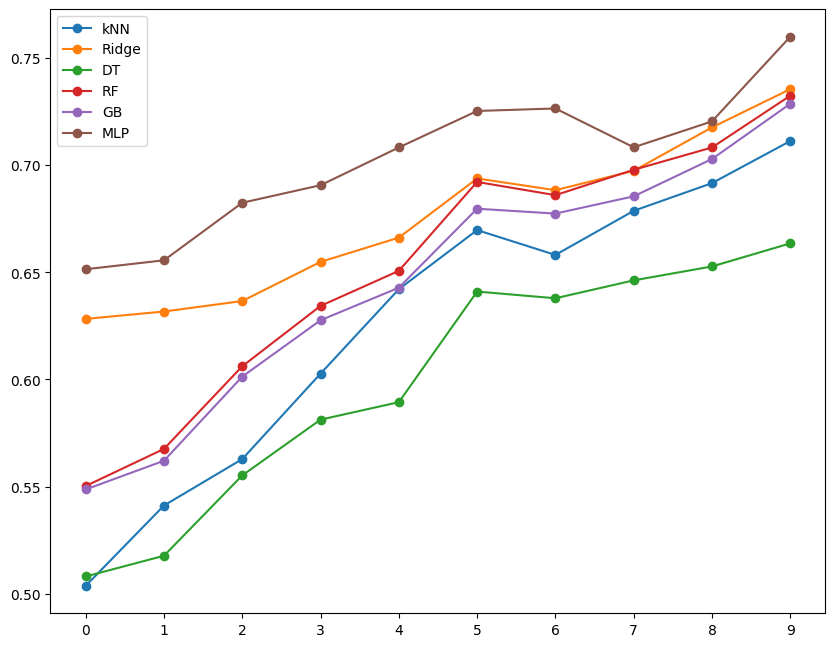

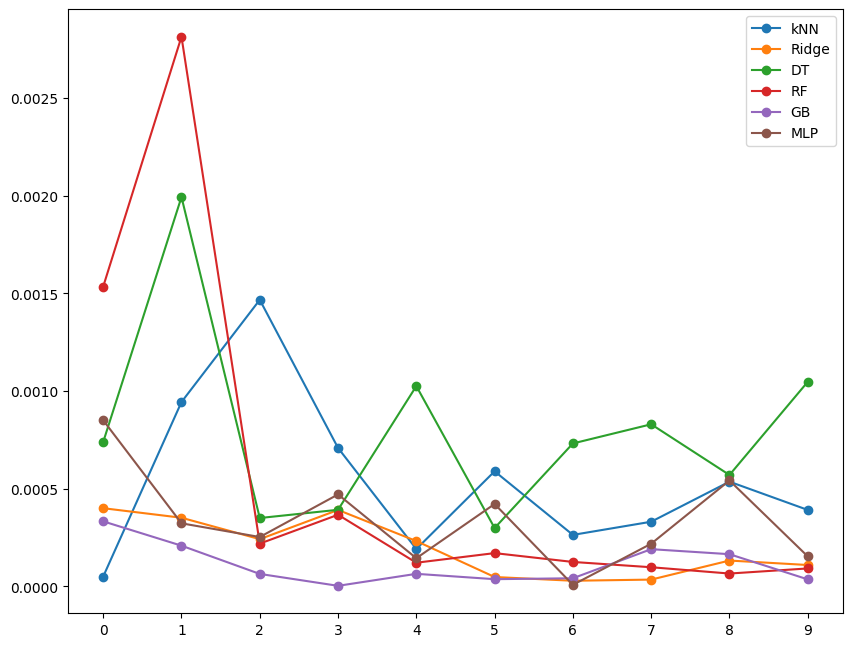

In [ ]:
day_list = ['1','2','3','4', '5', '6', '7', '8', '9', '10'] # 確定這個數量跟上面跑的 for 數量一樣
mean_scores = scores_summary(kNN_mean_score, RD_mean_score, DT_mean_score, RF_mean_score, GB_mean_score, MLP_mean_score)
var_scores = scores_summary(kNN_var_score, RD_var_score, DT_var_score, RF_var_score, GB_var_score, MLP_var_score)
plot_all(day_list, mean_scores , name = '聯電CV1_mean', save = True)
plot_all(day_list, var_scores , name = '聯電CV1_var', save = True)
mean_scores.to_excel(workdata_path + '/聯電CV1_mean.xlsx')
var_scores.to_excel(workdata_path + '/聯電CV1_var.xlsx')

## Best cutoff

In [ ]:
### 測試 2：要用幾 % 當漲跌幅最適合
for i in trange(8, 10): 
    print('This is', i+1, 'times')
    def diff(data, d = 1):
        return (data[d]-data[0]) / data[0] 
    def eval(ratio, cutoff = (i/100)):
        if ratio >= cutoff:
            label = "漲"
        elif ratio < -cutoff:
            label = "跌"
        else:
            label = nan
        return label

    stock_data = extend_stock(stock_rawdata, window = 2)
    stock_data, main_df = merge_stock_text(stock_data, article_df, D=2)
    X_all = get_tfidf_matrix(stopwords, allWords)
    y_all = main_df[main_df['post_time'].between(all_startDate, all_endDate)]['label']
    X_all = get_X_y2(X_all, article_df, main_df, all_startDate, all_endDate)
    X_all, y_all = reset_Xy_index(X_all, y_all)
    X_all, k_features = featuring_X(X_all, y_all, k= 2000, method = chi2) 
    
    #演算法
    scores = ML_all(X_all, y_all, cv_number = 5)
    kNN_mean_score, kNN_var_score = scores_append(scores[0], kNN_mean_score, kNN_var_score)
    RD_mean_score, RD_var_score = scores_append(scores[1], RD_mean_score, RD_var_score)
    DT_mean_score, DT_var_score = scores_append(scores[2], DT_mean_score, DT_var_score)
    RF_mean_score, RF_var_score = scores_append(scores[3], RF_mean_score, RF_var_score)
    GB_mean_score, GB_var_score = scores_append(scores[4], GB_mean_score, GB_var_score)
    MLP_mean_score, MLP_var_score = scores_append(scores[5], MLP_mean_score, MLP_var_score)


  0%|                                                     | 0/2 [00:00<?, ?it/s]

This is 9 times



 50%|██████████████████████                      | 1/2 [02:21<02:21, 141.07s/it]

kNN: [0.97706422 0.97706422 0.97591743 0.97703789 0.97703789] 
Ridge: [0.97706422 0.97706422 0.97591743 0.97703789 0.97703789] 
DT: [0.96788991 0.95986239 0.97018349 0.96326062 0.96326062] 
RF: [0.97591743 0.97706422 0.97591743 0.97474168 0.97588978] 
GB: [0.96559633 0.9690367  0.9690367  0.96900115 0.97014925] 
MLP: [0.97591743 0.97706422 0.97477064 0.97359357 0.97588978]
This is 10 times


100%|████████████████████████████████████████████| 2/2 [04:38<00:00, 139.02s/it]

kNN: [0.98050459 0.98050459 0.98050459 0.9804822  0.9804822 ] 
Ridge: [0.98050459 0.98050459 0.98050459 0.9804822  0.9804822 ] 
DT: [0.9690367  0.97018349 0.97706422 0.95637199 0.97359357] 
RF: [0.9793578  0.9793578  0.98050459 0.97818599 0.9804822 ] 
GB: [0.97018349 0.97362385 0.97591743 0.96555683 0.97359357] 
MLP: [0.9793578  0.9793578  0.98050459 0.97588978 0.9804822 ]


        kNN     Ridge        DT        RF        GB       MLP
0  0.503670  0.628278  0.509186  0.553942  0.548193  0.649855
1  0.635154  0.663382  0.578711  0.644800  0.632871  0.711341
2  0.756544  0.764572  0.708132  0.754019  0.758150  0.774899
3  0.850620  0.851078  0.819192  0.843967  0.847637  0.846950
4  0.906609  0.906609  0.880682  0.904314  0.905002  0.906149
5  0.942864  0.942405  0.924051  0.939882  0.937588  0.941028
6  0.966269  0.966040  0.952961  0.963975  0.954340  0.963745
7  0.976824  0.976824  0.968334  0.975906  0.967646  0.975447
8  0.976824  0.976824  0.964891  0.975906  0.968564  0.975447
9  0.980496  0.980496  0.969250  0.979578  0.971775  0.979118
            kNN         Ridge        DT            RF        GB       MLP
0  5.012938e-05  4.000630e-04  0.000927  2.246838e-03  0.000393  0.001076
1  4.178959e-04  2.375284e-04  0.000572  7.769057e-04  0.001123  0.000270
2  2.242909e-04  1.652171e-05  0.001218  1.323532e-04  0.000110  0.000102
3  1.860452e-07  7.749

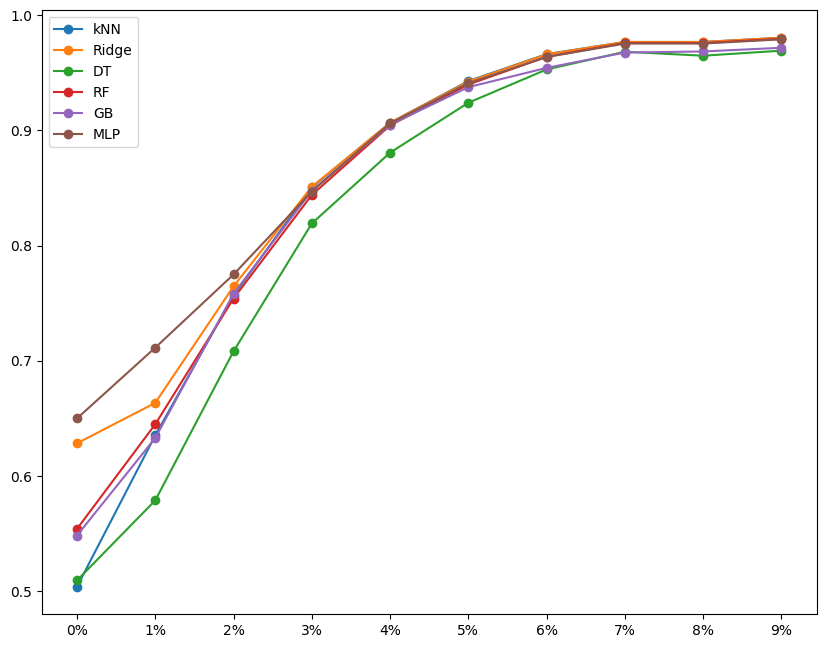

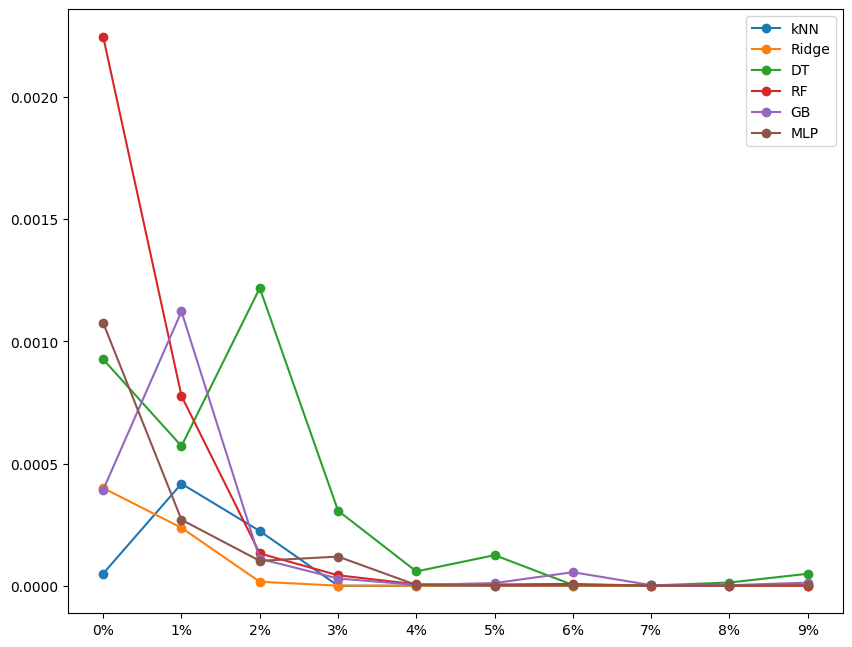

In [ ]:
percent_list = ['0%','1%','2%','3%','4%', '5%', '6%', '7%', '8%', '9%'] # 確定這個數量跟上面跑的 for 數量一樣
mean_scores = scores_summary(kNN_mean_score, RD_mean_score, DT_mean_score, RF_mean_score, GB_mean_score, MLP_mean_score)
var_scores = scores_summary(kNN_var_score, RD_var_score, DT_var_score, RF_var_score, GB_var_score, MLP_var_score)
plot_all(percent_list, mean_scores , name = '聯電CV2_mean', save = True)
plot_all(percent_list, var_scores , name = '聯電CV2_var', save = True)
mean_scores.to_excel(workdata_path + '/聯電CV2_mean.xlsx')
var_scores.to_excel(workdata_path + '/聯電CV2_var.xlsx')


## Best Cutoff & Lag

In [ ]:
### 測試 2.5：結合前兩個測試
for i in trange(5):
    print('This is', i+1, 'times')
    def diff(data, d = (i+1)):
        return (data[d]-data[0]) / data[0] 
    
    for j in trange(6):
        def eval(ratio, cutoff = (j/100)):
            if ratio >= cutoff:
                label = "漲"
            elif ratio < -cutoff:
                label = "跌"
            else:
                label = nan
            return label

        stock_data = extend_stock(stock_rawdata, window = (i+2))
        stock_data, main_df = merge_stock_text(stock_data, article_df, D = (i+1))
        X_all = get_tfidf_matrix(stopwords, allWords)
        y_all = main_df[main_df['post_time'].between(all_startDate, all_endDate)]['label']
        X_all = get_X_y2(X_all, article_df, main_df, all_startDate, all_endDate)
        X_all, y_all = reset_Xy_index(X_all, y_all)
        X_all, k_features = featuring_X(X_all, y_all, k= 2000, method = chi2) 

        #演算法
        scores = ML_all(X_all, y_all, cv_number = 5)
        kNN_mean_score, kNN_var_score = scores_append(scores[0], kNN_mean_score, kNN_var_score)
        RD_mean_score, RD_var_score = scores_append(scores[1], RD_mean_score, RD_var_score)
        DT_mean_score, DT_var_score = scores_append(scores[2], DT_mean_score, DT_var_score)
        RF_mean_score, RF_var_score = scores_append(scores[3], RF_mean_score, RF_var_score)
        GB_mean_score, GB_var_score = scores_append(scores[4], GB_mean_score, GB_var_score)
        MLP_mean_score, MLP_var_score = scores_append(scores[5], MLP_mean_score, MLP_var_score)
        


  0%|                                                     | 0/5 [00:00<?, ?it/s]

This is 1 times



 17%|███████▎                                    | 1/6 [03:56<19:41, 236.23s/it]

kNN: [0.50802752 0.5        0.50917431 0.5097589  0.49138921] 
Ridge: [0.61123853 0.62155963 0.61582569 0.62571757 0.66704937] 
DT: [0.5309633  0.44954128 0.50688073 0.52353617 0.5304248 ] 
RF: [0.57568807 0.47591743 0.54701835 0.60275545 0.59012629] 
GB: [0.51376147 0.56766055 0.53555046 0.54994259 0.57290471] 
MLP: [0.63073394 0.65366972 0.63646789 0.66016073 0.70378875]



 33%|██████████████▋                             | 2/6 [06:47<13:12, 198.07s/it]

kNN: [0.50330033 0.52231405 0.50082645 0.52892562 0.55041322] 
Ridge: [0.63861386 0.60991736 0.64793388 0.65123967 0.64297521] 
DT: [0.49669967 0.51570248 0.47768595 0.54214876 0.54710744] 
RF: [0.5660066  0.55867769 0.5768595  0.60826446 0.59173554] 
GB: [0.50660066 0.52396694 0.5338843  0.56694215 0.56694215] 
MLP: [0.65676568 0.62975207 0.68264463 0.69586777 0.68595041]



 50%|██████████████████████                      | 3/6 [08:41<07:58, 159.63s/it]

kNN: [0.51690821 0.52058111 0.51815981 0.50363196 0.46246973] 
Ridge: [0.647343   0.61743341 0.6464891  0.66828087 0.60048426] 
DT: [0.49275362 0.50847458 0.46973366 0.54237288 0.52300242] 
RF: [0.57729469 0.53510896 0.54237288 0.59806295 0.57869249] 
GB: [0.53864734 0.52784504 0.55690073 0.57142857 0.54479419] 
MLP: [0.63285024 0.62711864 0.68038741 0.73849879 0.67312349]



 67%|█████████████████████████████▎              | 4/6 [09:57<04:13, 126.60s/it]

kNN: [0.52589641 0.52191235 0.51792829 0.532      0.5       ] 
Ridge: [0.64541833 0.62151394 0.62948207 0.66       0.652     ] 
DT: [0.58565737 0.54183267 0.50199203 0.5        0.488     ] 
RF: [0.60159363 0.5498008  0.53386454 0.584      0.584     ] 
GB: [0.52988048 0.56175299 0.58964143 0.576      0.568     ] 
MLP: [0.70119522 0.70916335 0.71314741 0.732      0.732     ]



 83%|████████████████████████████████████▋       | 5/6 [10:50<01:40, 100.22s/it]

kNN: [0.55555556 0.48611111 0.5        0.54861111 0.52083333] 
Ridge: [0.60416667 0.625      0.67361111 0.70138889 0.57638889] 
DT: [0.56944444 0.61111111 0.5625     0.52777778 0.58333333] 
RF: [0.56944444 0.64583333 0.625      0.65277778 0.57638889] 
GB: [0.59722222 0.57638889 0.63194444 0.68055556 0.60416667] 
MLP: [0.71527778 0.65277778 0.68055556 0.8125     0.68055556]



 20%|████████▊                                   | 1/5 [11:28<45:54, 688.69s/it]

kNN: [0.54347826 0.54347826 0.5326087  0.51648352 0.54945055] 
Ridge: [0.65217391 0.70652174 0.57608696 0.67032967 0.73626374] 
DT: [0.52173913 0.5326087  0.51086957 0.57142857 0.62637363] 
RF: [0.59782609 0.59782609 0.56521739 0.67032967 0.71428571] 
GB: [0.56521739 0.65217391 0.52173913 0.64835165 0.63736264] 
MLP: [0.75       0.7173913  0.65217391 0.75824176 0.78021978]
This is 2 times



 17%|███████▎                                    | 1/6 [03:06<15:31, 186.34s/it]

kNN: [0.56925208 0.5520111  0.52843273 0.49930652 0.53536755] 
Ridge: [0.68282548 0.62413315 0.6629681  0.62829404 0.60471567] 
DT: [0.54847645 0.54923717 0.52149792 0.50485437 0.52704577] 
RF: [0.63296399 0.58113731 0.58807212 0.56865465 0.59916782] 
GB: [0.60249307 0.52843273 0.54646325 0.52011096 0.53814147] 
MLP: [0.67174515 0.65464632 0.66574202 0.68793343 0.67128988]



 33%|██████████████▋                             | 2/6 [05:35<10:58, 164.55s/it]

kNN: [0.49122807 0.5122807  0.54736842 0.51845343 0.50087873] 
Ridge: [0.61578947 0.64912281 0.65087719 0.67135325 0.66783831] 
DT: [0.59122807 0.5        0.53859649 0.53602812 0.56766257] 
RF: [0.62807018 0.51929825 0.5754386  0.57644991 0.61335677] 
GB: [0.54736842 0.54385965 0.53333333 0.56766257 0.53954306] 
MLP: [0.66315789 0.62105263 0.6754386  0.72407733 0.71177504]



 50%|██████████████████████                      | 3/6 [07:33<07:09, 143.21s/it]

kNN: [0.61956522 0.54684096 0.52941176 0.50108932 0.59259259] 
Ridge: [0.63913043 0.72331155 0.65141612 0.7037037  0.69498911] 
DT: [0.58043478 0.55119826 0.51851852 0.5577342  0.54901961] 
RF: [0.60652174 0.5751634  0.5664488  0.5751634  0.59694989] 
GB: [0.55869565 0.5751634  0.52069717 0.59259259 0.59259259] 
MLP: [0.69347826 0.66448802 0.68191721 0.70588235 0.73202614]



 67%|█████████████████████████████▎              | 4/6 [09:03<04:04, 122.17s/it]

kNN: [0.48606811 0.52631579 0.51702786 0.49535604 0.56521739] 
Ridge: [0.63157895 0.69040248 0.69659443 0.71517028 0.69565217] 
DT: [0.56656347 0.52321981 0.48297214 0.48916409 0.57453416] 
RF: [0.60681115 0.59442724 0.56037152 0.625387   0.59937888] 
GB: [0.56346749 0.53869969 0.57894737 0.55727554 0.5931677 ] 
MLP: [0.72755418 0.6996904  0.70897833 0.75541796 0.81677019]



 83%|████████████████████████████████████▋       | 5/6 [10:09<01:42, 102.01s/it]

kNN: [0.5        0.54201681 0.54621849 0.4978903  0.53164557] 
Ridge: [0.75210084 0.61344538 0.79411765 0.67932489 0.67510549] 
DT: [0.57142857 0.51680672 0.50420168 0.54008439 0.57805907] 
RF: [0.65966387 0.51260504 0.68067227 0.5907173  0.61603376] 
GB: [0.57563025 0.46638655 0.57142857 0.5443038  0.60337553] 
MLP: [0.68487395 0.65546218 0.76890756 0.81434599 0.75949367]



 40%|█████████████████▌                          | 2/5 [22:35<33:47, 675.79s/it]

kNN: [0.4619883  0.47953216 0.59649123 0.55555556 0.52941176] 
Ridge: [0.76023392 0.59064327 0.74853801 0.71345029 0.69411765] 
DT: [0.56140351 0.50292398 0.62573099 0.56140351 0.53529412] 
RF: [0.64327485 0.5380117  0.70760234 0.65497076 0.63529412] 
GB: [0.6374269  0.52631579 0.61403509 0.60818713 0.54117647] 
MLP: [0.78362573 0.68421053 0.74853801 0.77777778 0.77058824]
This is 3 times



 17%|███████▎                                    | 1/6 [03:12<16:00, 192.02s/it]

kNN: [0.55960729 0.56100982 0.56460674 0.56741573 0.5252809 ] 
Ridge: [0.66339411 0.66900421 0.65730337 0.64466292 0.62921348] 
DT: [0.57082749 0.55820477 0.5238764  0.51123596 0.5744382 ] 
RF: [0.65357644 0.60729313 0.61376404 0.59129213 0.60674157] 
GB: [0.58064516 0.57082749 0.59410112 0.55196629 0.58848315] 
MLP: [0.72370266 0.62412342 0.6741573  0.69101124 0.69803371]



 33%|██████████████▋                             | 2/6 [05:35<10:53, 163.46s/it]

kNN: [0.65404475 0.57241379 0.55689655 0.55862069 0.55172414] 
Ridge: [0.67125645 0.68448276 0.6862069  0.65       0.64310345] 
DT: [0.5404475  0.55862069 0.57241379 0.56551724 0.56724138] 
RF: [0.63339071 0.63103448 0.64137931 0.63965517 0.61206897] 
GB: [0.62650602 0.60344828 0.57931034 0.59310345 0.59482759] 
MLP: [0.73493976 0.61551724 0.68793103 0.75       0.69827586]



 50%|██████████████████████                      | 3/6 [07:44<07:23, 147.89s/it]

kNN: [0.61054767 0.60446247 0.5821501  0.54268293 0.56097561] 
Ridge: [0.64908722 0.67545639 0.663286   0.70121951 0.65853659] 
DT: [0.59634888 0.56795132 0.54563895 0.60162602 0.54471545] 
RF: [0.61866126 0.62068966 0.64908722 0.64430894 0.6097561 ] 
GB: [0.61257606 0.60649087 0.56389452 0.63617886 0.59756098] 
MLP: [0.72819473 0.67342799 0.663286   0.75813008 0.73577236]



 67%|█████████████████████████████▎              | 4/6 [09:25<04:18, 129.08s/it]

kNN: [0.585  0.56   0.605  0.5975 0.5725] 
Ridge: [0.655  0.6075 0.6875 0.6675 0.6475] 
DT: [0.5675 0.48   0.5575 0.585  0.5825] 
RF: [0.6525 0.56   0.65   0.6275 0.62  ] 
GB: [0.61  0.605 0.585 0.62  0.615] 
MLP: [0.745  0.6225 0.6675 0.7525 0.7475]



 83%|████████████████████████████████████▋       | 5/6 [10:56<01:55, 115.35s/it]

kNN: [0.61180124 0.46417445 0.6635514  0.61370717 0.63239875] 
Ridge: [0.67391304 0.59190031 0.69158879 0.69781931 0.63862928] 
DT: [0.5310559  0.42367601 0.51713396 0.59501558 0.58255452] 
RF: [0.64906832 0.46105919 0.63862928 0.6635514  0.6105919 ] 
GB: [0.64285714 0.4517134  0.59190031 0.65420561 0.61370717] 
MLP: [0.74223602 0.6105919  0.66043614 0.7788162  0.7258567 ]



 60%|██████████████████████████▍                 | 3/5 [34:48<23:24, 702.11s/it]

kNN: [0.60984848 0.45833333 0.5530303  0.56273764 0.59695817] 
Ridge: [0.75378788 0.53787879 0.68560606 0.65019011 0.64638783] 
DT: [0.57575758 0.48106061 0.51515152 0.61596958 0.63498099] 
RF: [0.625      0.46590909 0.64772727 0.64258555 0.63498099] 
GB: [0.69318182 0.4469697  0.5719697  0.69581749 0.61596958] 
MLP: [0.71590909 0.62121212 0.65909091 0.69201521 0.68441065]
This is 4 times



 17%|███████▎                                    | 1/6 [02:58<14:50, 178.18s/it]

kNN: [0.56378601 0.5829904  0.60082305 0.56378601 0.57475995] 
Ridge: [0.63648834 0.67901235 0.65020576 0.65432099 0.64883402] 
DT: [0.54595336 0.5733882  0.55006859 0.5473251  0.56104252] 
RF: [0.60082305 0.62414266 0.62139918 0.61591221 0.59670782] 
GB: [0.57613169 0.57887517 0.5994513  0.58024691 0.58710562] 
MLP: [0.7037037  0.6351166  0.65294925 0.71193416 0.70781893]



 33%|██████████████▋                             | 2/6 [05:31<10:53, 163.27s/it]

kNN: [0.60350318 0.55502392 0.55661882 0.58692185 0.55023923] 
Ridge: [0.6544586  0.6507177  0.63955343 0.64752791 0.6507177 ] 
DT: [0.56687898 0.53110048 0.54385965 0.54864434 0.56299841] 
RF: [0.61305732 0.59330144 0.61722488 0.59808612 0.58692185] 
GB: [0.59872611 0.58373206 0.59489633 0.59011164 0.58373206] 
MLP: [0.71178344 0.67464115 0.64593301 0.68580542 0.73205742]



 50%|██████████████████████                      | 3/6 [07:56<07:46, 155.35s/it]

kNN: [0.6130742  0.60070671 0.58303887 0.61946903 0.54867257] 
Ridge: [0.65017668 0.69081272 0.66961131 0.6460177  0.63893805] 
DT: [0.57243816 0.54063604 0.52826855 0.5380531  0.56460177] 
RF: [0.61484099 0.6360424  0.63427562 0.61946903 0.56637168] 
GB: [0.61660777 0.59187279 0.60424028 0.64070796 0.56460177] 
MLP: [0.71908127 0.68021201 0.67314488 0.73982301 0.71858407]



 67%|█████████████████████████████▎              | 4/6 [10:01<04:45, 143.00s/it]

kNN: [0.62288136 0.51271186 0.61228814 0.60381356 0.58174098] 
Ridge: [0.67161017 0.65889831 0.68220339 0.65889831 0.62420382] 
DT: [0.58898305 0.54872881 0.53389831 0.58262712 0.57749469] 
RF: [0.65677966 0.61228814 0.6440678  0.63983051 0.59235669] 
GB: [0.63559322 0.625      0.6059322  0.65254237 0.6029724 ] 
MLP: [0.75211864 0.65042373 0.68008475 0.72669492 0.70276008]



 83%|████████████████████████████████████▋       | 5/6 [11:51<02:11, 131.38s/it]

kNN: [0.62560386 0.56900726 0.57142857 0.62711864 0.61985472] 
Ridge: [0.68115942 0.68038741 0.62711864 0.66343826 0.6440678 ] 
DT: [0.60628019 0.5496368  0.53995157 0.52058111 0.57142857] 
RF: [0.68115942 0.57142857 0.62227603 0.64164649 0.61016949] 
GB: [0.64975845 0.62953995 0.59806295 0.63680387 0.63438257] 
MLP: [0.75603865 0.68038741 0.65375303 0.73849879 0.71670702]



 80%|███████████████████████████████████▏        | 4/5 [48:26<12:27, 747.79s/it]

kNN: [0.63934426 0.56010929 0.66393443 0.60547945 0.61643836] 
Ridge: [0.68306011 0.69945355 0.67759563 0.67945205 0.65753425] 
DT: [0.63661202 0.53551913 0.54371585 0.56986301 0.62739726] 
RF: [0.67213115 0.63387978 0.63114754 0.65753425 0.63835616] 
GB: [0.65027322 0.63387978 0.63114754 0.66849315 0.64109589] 
MLP: [0.72677596 0.71584699 0.68032787 0.73424658 0.72876712]
This is 5 times



 17%|███████▎                                    | 1/6 [03:12<16:04, 192.87s/it]

kNN: [0.60477454 0.5596817  0.57104914 0.57636122 0.5750332 ] 
Ridge: [0.66047745 0.64986737 0.64010624 0.6812749  0.65338645] 
DT: [0.5596817  0.55570292 0.5936255  0.53917663 0.54581673] 
RF: [0.63527851 0.62068966 0.62151394 0.64143426 0.62948207] 
GB: [0.60344828 0.58222812 0.63346614 0.62682603 0.60292165] 
MLP: [0.71750663 0.67374005 0.69189907 0.70385126 0.71314741]



 33%|██████████████▋                             | 2/6 [06:04<12:00, 180.20s/it]

kNN: [0.59792285 0.61721068 0.56166419 0.56760773 0.57800892] 
Ridge: [0.65875371 0.65133531 0.62704309 0.70430906 0.653789  ] 
DT: [0.58160237 0.53857567 0.5423477  0.58098068 0.56017831] 
RF: [0.63501484 0.615727   0.60475483 0.65824666 0.63001486] 
GB: [0.59940653 0.60979228 0.62852897 0.64041605 0.6166419 ] 
MLP: [0.70919881 0.66765579 0.67013373 0.71173848 0.7013373 ]



 50%|██████████████████████                      | 3/6 [08:46<08:36, 172.16s/it]

kNN: [0.62622951 0.58360656 0.54262295 0.5500821  0.5270936 ] 
Ridge: [0.66721311 0.69344262 0.6704918  0.67816092 0.63054187] 
DT: [0.58196721 0.55737705 0.58032787 0.56321839 0.54515599] 
RF: [0.63114754 0.61639344 0.63934426 0.62397373 0.58949097] 
GB: [0.61639344 0.61803279 0.6295082  0.6272578  0.61904762] 
MLP: [0.7147541  0.67213115 0.7        0.71428571 0.66502463]



 67%|█████████████████████████████▎              | 4/6 [11:15<05:25, 162.97s/it]

kNN: [0.60952381 0.57061069 0.55725191 0.58396947 0.57442748] 
Ridge: [0.68380952 0.70419847 0.67366412 0.69083969 0.64312977] 
DT: [0.59809524 0.50572519 0.59541985 0.60114504 0.54389313] 
RF: [0.65142857 0.59732824 0.6278626  0.6240458  0.62022901] 
GB: [0.62857143 0.60305344 0.60687023 0.61832061 0.61068702] 
MLP: [0.71428571 0.65839695 0.6851145  0.70992366 0.68129771]



 83%|████████████████████████████████████▋       | 5/6 [13:11<02:26, 146.00s/it]

kNN: [0.63192905 0.57649667 0.60222222 0.59777778 0.59333333] 
Ridge: [0.70066519 0.70288248 0.69777778 0.65333333 0.65333333] 
DT: [0.64301552 0.56097561 0.54444444 0.59111111 0.58666667] 
RF: [0.68292683 0.68514412 0.65777778 0.62888889 0.64888889] 
GB: [0.64966741 0.61419069 0.62       0.63333333 0.64222222] 
MLP: [0.7405765  0.68514412 0.71111111 0.74888889 0.69555556]



100%|██████████████████████████████████████████| 5/5 [1:03:28<00:00, 761.62s/it]

kNN: [0.60789474 0.57894737 0.56842105 0.61842105 0.58947368] 
Ridge: [0.74210526 0.75526316 0.76315789 0.67368421 0.64736842] 
DT: [0.72894737 0.59210526 0.65263158 0.59210526 0.58421053] 
RF: [0.72894737 0.68157895 0.70789474 0.65789474 0.63421053] 
GB: [0.65       0.6        0.64736842 0.66052632 0.63684211] 
MLP: [0.75526316 0.68947368 0.69473684 0.77105263 0.68157895]


In [ ]:
mean_scores = scores_summary(kNN_mean_score, RD_mean_score, DT_mean_score, RF_mean_score, GB_mean_score, MLP_mean_score)

mean_scores_rank = pd.DataFrame()
mean_scores_rank['day'] = [1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4, 4, 5, 5, 5, 5, 5, 5]
mean_scores_rank['%'] = list(range(6))*5
mean_scores_rank['kNN'] = mean_scores['kNN'].rank(method='max', ascending= False)
mean_scores_rank['Ridge'] = mean_scores['Ridge'].rank(method='max', ascending= False)
mean_scores_rank['DT'] = mean_scores['DT'].rank(method='max', ascending= False)
mean_scores_rank['RF'] = mean_scores['RF'].rank(method='max', ascending= False)
mean_scores_rank['GB'] = mean_scores['GB'].rank(method='max', ascending= False)
mean_scores_rank['MLP'] = mean_scores['MLP'].rank(method='max', ascending= False)
mean_scores_rank


         kNN     Ridge        DT        RF        GB       MLP
0   0.503670  0.628278  0.508269  0.558301  0.547964  0.656964
1   0.521156  0.638136  0.515869  0.580309  0.539667  0.670196
2   0.504350  0.636006  0.507267  0.566306  0.547923  0.670396
3   0.519547  0.641683  0.523496  0.570652  0.565055  0.717501
4   0.522222  0.636111  0.570833  0.613889  0.618056  0.708333
5   0.537100  0.668275  0.552604  0.629097  0.604969  0.731605
6   0.536874  0.640587  0.530222  0.593999  0.547128  0.670271
7   0.514042  0.650996  0.546703  0.582523  0.546353  0.679100
8   0.557900  0.682510  0.551381  0.584049  0.567948  0.695558
9   0.517997  0.685880  0.527291  0.597275  0.566312  0.741682
10  0.523554  0.702819  0.542116  0.611938  0.552225  0.736617
11  0.524596  0.701397  0.557351  0.635831  0.585428  0.752948
12  0.555584  0.652716  0.547717  0.614533  0.577205  0.682206
13  0.578740  0.667010  0.560848  0.631506  0.599439  0.697333
14  0.580164  0.669517  0.571256  0.628501  0.603340  0

,day,%,kNN,Ridge,DT,RF,GB,MLP
0,1,0,30.0,30.0,29.0,30.0,26.0,30.0
1,1,1,25.0,27.0,28.0,27.0,30.0,29.0
2,1,2,29.0,29.0,30.0,29.0,27.0,27.0
3,1,3,26.0,25.0,27.0,28.0,24.0,6.0
4,1,4,24.0,28.0,5.0,17.0,8.0,11.0
5,1,5,20.0,10.0,17.0,7.0,12.0,4.0
6,2,0,21.0,26.0,24.0,24.0,28.0,28.0
7,2,1,28.0,23.0,22.0,26.0,29.0,25.0
8,2,2,17.0,5.0,18.0,25.0,22.0,18.0
9,2,3,27.0,4.0,26.0,23.0,23.0,2.0


In [ ]:
#mean_scores['kNN']+mean_scores['Ridge']+mean_scores['DT']+mean_scores['RF']+mean_scores['GB']+mean_scores['MLP']
mean_scores2 = mean_scores.drop(index = [4, 5, 10, 11, 16, 17, 22, 23, 28, 29])
mean_scores2 = mean_scores2.reset_index(drop = True)
mean_all = []
mean_all.extend(mean_scores2['kNN'])
mean_all.extend(mean_scores2['Ridge'])
mean_all.extend(mean_scores2['DT'])
mean_all.extend(mean_scores2['RF'])
mean_all.extend(mean_scores2['GB'])
mean_all.extend(mean_scores2['MLP'])
mean_all = pd.DataFrame(mean_all)
mean_all_rank = mean_all.rank(method='max', ascending= False)

mean_scores_rank2 = pd.DataFrame()
mean_scores_rank2['day'] = [1, 1, 1, 1, 2, 2, 2, 2, 3, 3, 3, 3, 4, 4, 4, 4, 5, 5, 5, 5]
mean_scores_rank2['%'] = list(range(4))*5
mean_scores_rank2['kNN'] = mean_all_rank[0:20].reset_index(drop = True)
mean_scores_rank2['Ridge'] = mean_all_rank[20:40].reset_index(drop = True)
mean_scores_rank2['DT'] = mean_all_rank[40:60].reset_index(drop = True)
mean_scores_rank2['RF'] = mean_all_rank[60:80].reset_index(drop = True)
mean_scores_rank2['GB'] = mean_all_rank[80:100].reset_index(drop = True)
mean_scores_rank2['MLP'] = mean_all_rank[100:120].reset_index(drop = True)
mean_scores_rank2

,day,%,kNN,Ridge,DT,RF,GB,MLP
0,1,0,120.0,45.0,117.0,93.0,101.0,30.0
1,1,1,112.0,38.0,115.0,72.0,107.0,22.0
2,1,2,119.0,39.0,118.0,86.0,102.0,20.0
3,1,3,113.0,36.0,111.0,80.0,89.0,2.0
4,2,0,108.0,37.0,109.0,63.0,104.0,21.0
5,2,1,116.0,34.0,105.0,71.0,106.0,19.0
6,2,2,94.0,15.0,98.0,69.0,83.0,9.0
7,2,3,114.0,14.0,110.0,62.0,85.0,1.0
8,3,0,95.0,33.0,103.0,52.0,78.0,17.0
9,3,1,75.0,25.0,90.0,40.0,61.0,8.0


## Best k_words

In [ ]:
### 測試 3：要用 k 當多少最適合
k_list = [400, 800, 1200, 1600, 2000, 2400, 2800, 3200, 3600, 4000]
zero_word_ratio = []
j = 1
for i in k_list:
    print('This is', j, 'times')
    def diff(data, d = 2):
        return (data[d]-data[0]) / data[0] 
    def eval(ratio, cutoff = (3/100)):
        if ratio >= cutoff:
            label = "漲"
        elif ratio < -cutoff:
            label = "跌"
        else:
            label = nan
        return label

    stock_data = extend_stock(stock_rawdata, window = 3)
    stock_data, main_df = merge_stock_text(stock_data, article_df, D = 2)
    X_all = get_tfidf_matrix(stopwords, allWords)
    y_all = main_df[main_df['post_time'].between(all_startDate, all_endDate)]['label']
    X_all = get_X_y2(X_all, article_df, main_df, all_startDate, all_endDate)
    X_all, y_all = reset_Xy_index(X_all, y_all)
    X_all, k_features = featuring_X(X_all, y_all, k= i, method = chi2) 
    zero_word_ratio.append(len(X_all.columns[(X_all == 0).all()]) / i)  #計算 = 0 的比例
    
    #演算法
    scores = ML_all(X_all, y_all, cv_number = 5)
    kNN_mean_score, kNN_var_score = scores_append(scores[0], kNN_mean_score, kNN_var_score)
    RD_mean_score, RD_var_score = scores_append(scores[1], RD_mean_score, RD_var_score)
    DT_mean_score, DT_var_score = scores_append(scores[2], DT_mean_score, DT_var_score)
    RF_mean_score, RF_var_score = scores_append(scores[3], RF_mean_score, RF_var_score)
    GB_mean_score, GB_var_score = scores_append(scores[4], GB_mean_score, GB_var_score)
    MLP_mean_score, MLP_var_score = scores_append(scores[5], MLP_mean_score, MLP_var_score)
    j += 1

zero_word_dataframe = pd.DataFrame(columns = ['k', '0_ratio'])
zero_word_dataframe['k'] = k_list
zero_word_dataframe['0_ratio'] = zero_word_ratio
zero_word_dataframe # 多加這個是用來顯示 「k 個關鍵字中，X_test 裡面有多少個根本就從沒出現過」的比例

This is 1 times
kNN: [0.58204334 0.55417957 0.57275542 0.56346749 0.61490683] 
Ridge: [0.60371517 0.6130031  0.65944272 0.6749226  0.68944099] 
DT: [0.55727554 0.52321981 0.60681115 0.59752322 0.58074534] 
RF: [0.59752322 0.56346749 0.6501548  0.6501548  0.61490683] 
GB: [0.56965944 0.54489164 0.625387   0.62848297 0.63975155] 
MLP: [0.65634675 0.6501548  0.69040248 0.69040248 0.72670807]
This is 2 times
kNN: [0.57585139 0.52631579 0.56965944 0.55417957 0.61180124] 
Ridge: [0.6130031  0.6377709  0.6501548  0.67801858 0.70496894] 
DT: [0.59442724 0.53250774 0.58513932 0.51393189 0.57763975] 
RF: [0.6130031  0.58204334 0.6130031  0.6501548  0.65838509] 
GB: [0.56965944 0.55108359 0.58823529 0.63467492 0.6242236 ] 
MLP: [0.66873065 0.64705882 0.69659443 0.72136223 0.77329193]
This is 3 times
kNN: [0.54179567 0.54179567 0.57585139 0.58204334 0.59937888] 
Ridge: [0.6006192  0.65944272 0.69659443 0.69659443 0.7173913 ] 
DT: [0.56965944 0.53250774 0.49845201 0.51083591 0.55590062] 
RF: [0.597

,k,0_ratio
0,400,0.0
1,800,0.0
2,1200,0.0
3,1600,0.0
4,2000,0.0
5,2400,0.0
6,2800,0.0
7,3200,0.0
8,3600,0.0
9,4000,0.0


In [ ]:
### 測試 3：要用 k 當多少最適合

k_list = [400, 800, 1200, 1600, 2000, 2400, 2800, 3200, 3600, 4000]

j = 1
for i in k_list:
    print('This is', j, 'times')

    #Get X and Y
    stock_data = extend_stock(stock_rawdata, window = 3)
    stock_data, main_df = merge_stock_text(stock_data, article_df, D = 2)
    X_all = get_tfidf_matrix(stopwords, allWords)
    y_all = main_df[main_df['post_time'].between(all_startDate, all_endDate)]['label']
    X_all = get_X_y2(X_all, article_df, main_df, all_startDate, all_endDate)
    X_all, y_all = reset_Xy_index(X_all, y_all)
    X_all, k_features = featuring_X(X_all, y_all, k= i, method = chi2) 
    zero_word_ratio.append(len(X_all.columns[(X_all == 0).all()]) / i)  #計算 = 0 的比例
    
    #Run Algorithm
    scores = ML_all(X_all, y_all, cv_number = 5)
    kNN_mean_score = scores_append(scores[0], kNN_mean_score)
    RD_mean_score = scores_append(scores[1], RD_mean_score)
    DT_mean_score = scores_append(scores[2], DT_mean_score)
    RF_mean_score = scores_append(scores[3], RF_mean_score)
    GB_mean_score = scores_append(scores[4], GB_mean_score)
    MLP_mean_score = scores_append(scores[5], MLP_mean_score)
    
    j += 1

        kNN     Ridge        DT        RF        GB       MLP
0  0.577471  0.648105  0.573115  0.615241  0.601635  0.682803
1  0.567561  0.656783  0.560729  0.623318  0.593575  0.701408
2  0.568173  0.674128  0.533471  0.604111  0.576230  0.720614
3  0.545265  0.670404  0.527902  0.601010  0.579945  0.739825
4  0.517997  0.685880  0.528533  0.597304  0.568790  0.746638
5  0.529791  0.690220  0.519235  0.588620  0.570025  0.741053
6  0.532867  0.687126  0.526045  0.588612  0.560727  0.746009
7  0.516088  0.685272  0.516759  0.605357  0.561968  0.739192
8  0.529756  0.697039  0.534727  0.611536  0.553914  0.749099
9  0.497537  0.693327  0.539665  0.618982  0.558874  0.745997
        kNN     Ridge        DT        RF        GB       MLP
0  0.000437  0.001152  0.000906  0.001086  0.001396  0.000762
1  0.000782  0.001019  0.001001  0.000773  0.001007  0.001922
2  0.000523  0.001700  0.000710  0.000610  0.000651  0.002533
3  0.002247  0.001079  0.000735  0.000321  0.000439  0.002126
4  0.000

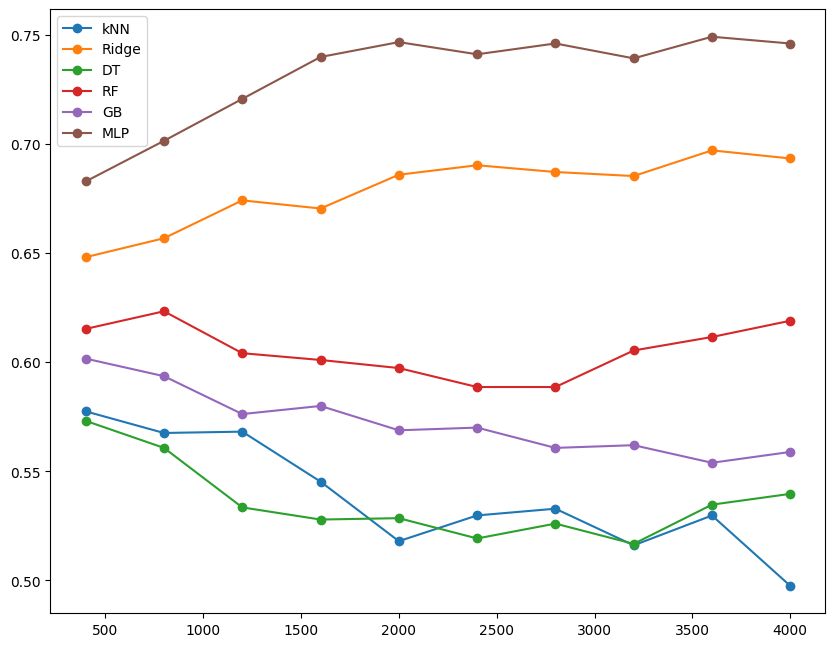

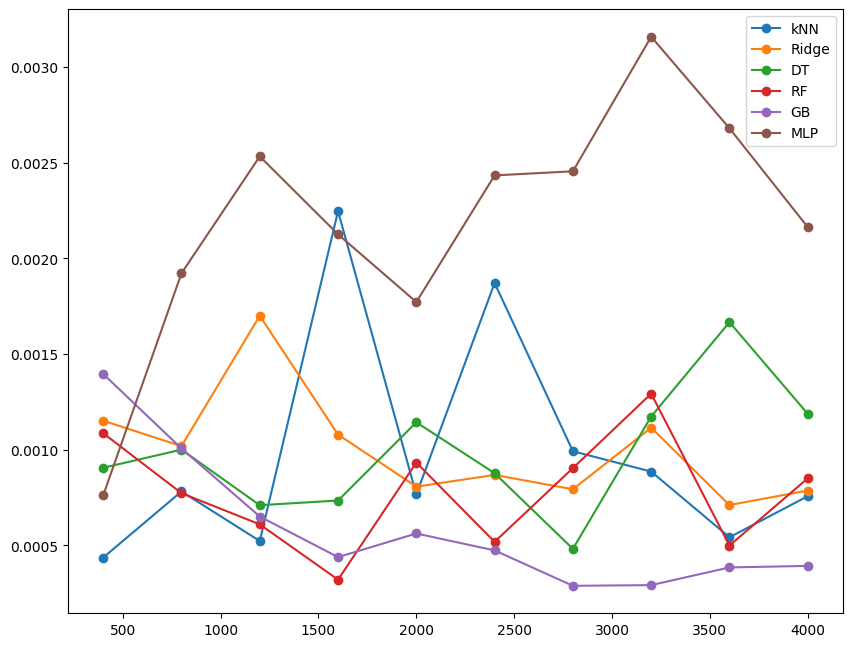

In [ ]:
mean_scores = scores_summary(kNN_mean_score, RD_mean_score, DT_mean_score, RF_mean_score, GB_mean_score, MLP_mean_score)
var_scores = scores_summary(kNN_var_score, RD_var_score, DT_var_score, RF_var_score, GB_var_score, MLP_var_score)
mean_scores.to_excel(workdata_path + '/聯電CV3_mean2.xlsx')
var_scores.to_excel(workdata_path + '/聯電CV3_var2.xlsx')
plot_all(k_list, mean_scores , name = '聯電CV3_mean2', save = True)
plot_all(k_list, var_scores , name = '聯電CV3_var2', save = True)

## Best parameter for Ridge/MLP

In [ ]:
### 測試 4：ridge/MLP 係數要用多少最適合
scores1 = []
scores2 = []
hidden_layer_sizes_list = [50, 100, 150, 200, 250, 300, 350, 400, 450, 500]
#alpha_list = [0.00001, 0.0001, 0.001, 0.01]
#list(np.arange(0.00, 0.05, 0.01, dtype=float))
j = 1
for i in hidden_layer_sizes_list:
    print('This is', j, 'times')
    def diff(data, d = 2):
        return (data[d]-data[0]) / data[0] 
    def eval(ratio, cutoff = (3/100)):
        if ratio >= cutoff:
            label = "漲"
        elif ratio < -cutoff:
            label = "跌"
        else:
            label = nan
        return label

    stock_data = extend_stock(stock_rawdata, window = 3)
    stock_data, main_df = merge_stock_text(stock_data, article_df, D = 2)
    X_all = get_tfidf_matrix(stopwords, allWords)
    y_all = main_df[main_df['post_time'].between(all_startDate, all_endDate)]['label']
    X_all = get_X_y2(X_all, article_df, main_df, all_startDate, all_endDate)
    X_all, y_all = reset_Xy_index(X_all, y_all)
    X_all, k_features = featuring_X(X_all, y_all, k= 2000, method = chi2) 
    
    MLPclf1 = MLPClassifier(solver='lbfgs',hidden_layer_sizes=[i])
    MLPscores1 = cross_val_score(MLPclf1, X_all, y_all, cv = 5)
    MLPclf2 = MLPClassifier(solver='lbfgs',hidden_layer_sizes=[i, i])
    MLPscores2 = cross_val_score(MLPclf2, X_all, y_all, cv = 5)
    print(np.mean(MLPscores1))
    print(np.mean(MLPscores2))
    scores1.append(np.mean(MLPscores1))
    scores2.append(np.mean(MLPscores2))
    
    #RDclf = RidgeClassifier(alpha = i)
    #RDscores = cross_val_score(RDclf, X_all, y_all, cv = 5)
    #print(np.mean(RDscores))
    #scores2.append(np.mean(RDscores))
    
    j += 1

This is 1 times
0.6982847143434032
0.6945695440647655
This is 2 times
0.6951945080091532
0.6976732111608945
This is 3 times
0.7026229256004461
0.7038555467953771
This is 4 times
0.6939465030863603
0.7032440436128684
This is 5 times
0.7013960733034632
0.7032363517489376
This is 6 times
0.6939484260523431
0.6958175489875585
This is 7 times
0.6958098571236275
0.6951906620771877
This is 8 times
0.694573389996731
0.6976578274330327
This is 9 times
0.6976635963309809
0.6989077553218083
This is 10 times
0.6989019864238601
0.6970424783185585


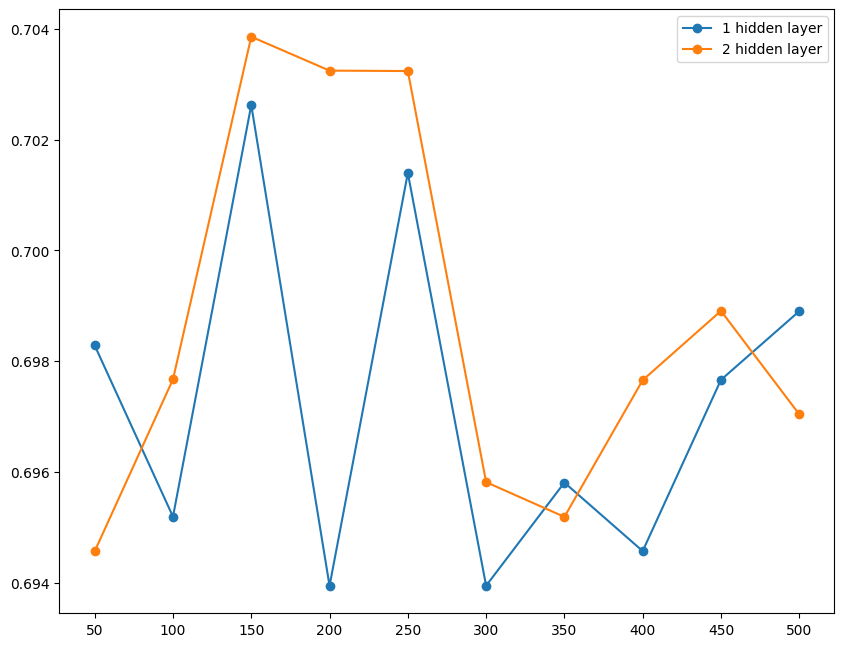

In [ ]:
scores_all = pd.DataFrame()
scores_all['i'] = np.arange(50, 501, step=50)
scores_all['1 hidden layer'] = scores1
scores_all['2 hidden layer'] = scores2
scores_all

plt.figure(figsize=(10, 8), dpi=100)
plt.xticks(np.arange(50, 501, step=50))
plt.plot(scores_all['i'], scores_all['1 hidden layer'], '-o', label="1 hidden layer")
plt.plot(scores_all['i'], scores_all['2 hidden layer'], '-o', label="2 hidden layer")
plt.legend(loc="best")
fig = plt.gcf()
fig.savefig(pic_path + '/' + '聯電CV4_mean_d2c3_3')
plt.show()

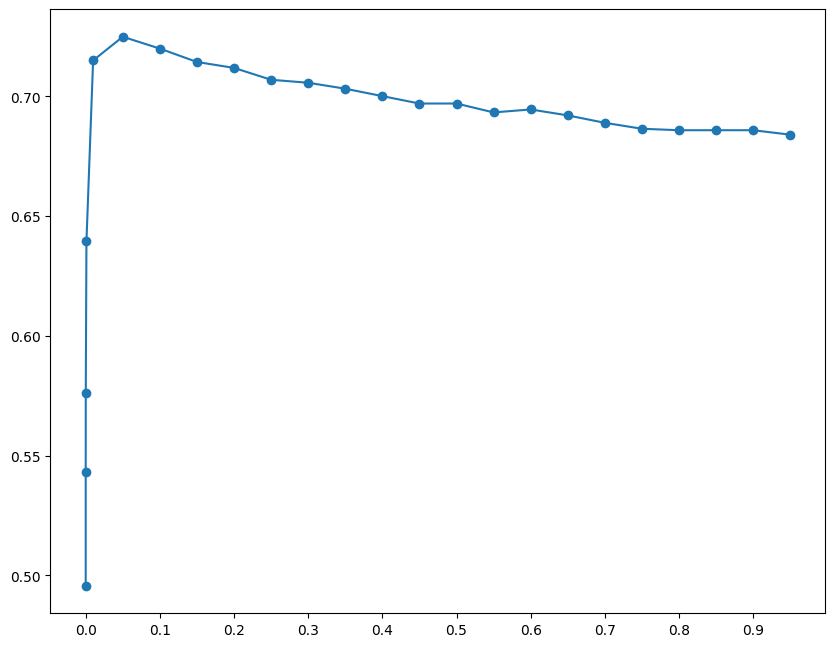

In [ ]:
scores_all = pd.DataFrame()
scores_all['alpha'] = index1
scores_all['accuracy'] = result1
scores_all

plt.figure(figsize=(10, 8), dpi=100)
plt.xticks(np.arange(0, 1, step=0.1))
plt.plot(scores_all['alpha'], scores_all['accuracy'], '-o')
fig = plt.gcf()
#fig.savefig(pic_path + '/' + '聯電CV4_mean_d2c3_2')
plt.show()